# A Life in Numbers
#### Life Tracker Data Analysis

In [1]:
import pandas as pd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import copy

times = ['midnight', '1am', '2am', '3am', '4am', '5am', '6am', '7am', '8am', '9am', '10am', 
        '11am', 'noon', '1pm', '2pm', '3pm', '4pm', '5pm', '6pm', '7pm', '8pm', '9pm', '10pm', '11pm']
col_names = copy.copy(times)
col_names.append('strain')
col_names.append('recovery')

categories = ['sleep', 'relax', 'productive', 'social', 'work / class', 'exercise', 'development', 'romance', 'family', 'wasted']

In [3]:
# Defining axes & reading in the data
dates = pd.date_range(start='1/1/2017', end='5/28/2018', freq='D')

raw = pd.read_csv('raw_data.csv', names=col_names)
# raw.rename(dates, axis='index')

# Making all entries lowercase
for col in raw:
    for i in range(0, len(raw[col])):
        if isinstance(raw[col][i], str):
            raw[col][i] = raw[col][i].lower()

In [4]:
NUM_CATEGORIES = len(categories)
NUM_DAYS = len(raw.midnight)
NUM_CATEGORIES

10

## ~ Constructing Dataframes ~

### The most likely thing to be doing at X hour DF:

In [5]:
countsDF = pd.DataFrame(columns = categories)
for index, row in raw[times].iterrows():
    
    counts_row = {}
    
    # resetting the counts dictionary
    for category in categories:
        counts_row[category] = 0
        
    # Iterating over the row, ie the hours in the day
    for entry in row:
        if categories.count(entry) > 0 :
            counts_row[entry] = counts_row[entry] + 1
    
    # Add the day's counts to the full matrix
    countsDF = countsDF.append(counts_row, ignore_index=True)
    
# countsDF

In [6]:
sums_by_time = pd.DataFrame(columns = categories)

for time in times:
    sums_by_time = sums_by_time.append(raw[time].value_counts())
    
sums_by_time.fillna(0, inplace=True)
sums_by_time.drop("#ref!", 1, inplace=True)
# sums_by_time

In [7]:
# sums_by_time:   by-time counts
# countsDF:       by-day counts

# ~GRAPHS~:

In [8]:
INDEX = np.arange(len(sums_by_time.index))
colors = ['tab:gray', 'tab:orange', 'tab:red', 'xkcd:fresh green', 'whitesmoke', 'b', 'mediumpurple', 'turquoise', 'violet', 'tab:brown']
names = sums_by_time.columns
plt.style.use('ggplot')

### Average by-day activity distribution:

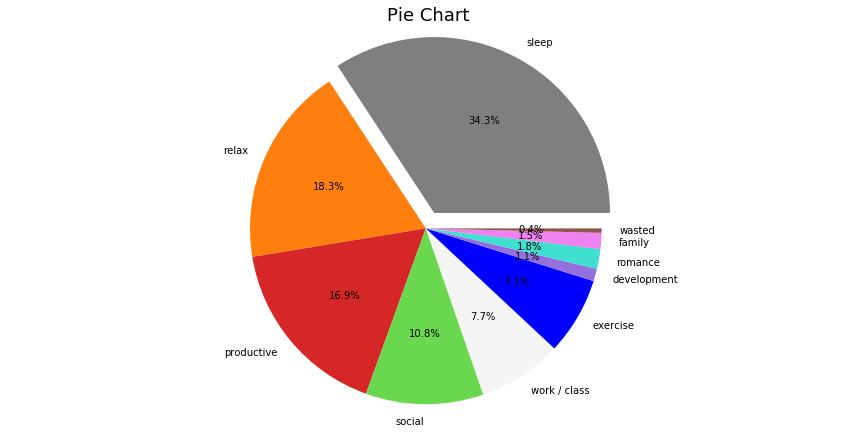

In [9]:
means_by_category = sums_by_time.mean(axis=0)
mean_hours_by_day_by_category = means_by_category * (24 / (sum(means_by_category)))
mean_hours_by_day_by_category

fig, ax = plt.subplots(figsize=(12,6))
plt.margins(0,0.025)

subset = categories
explode = [0] * len(subset)
explode[0] = 0.1

patches, texts, autotexts = ax.pie(mean_hours_by_day_by_category, explode=explode,
                                   labels=subset, colors=colors, autopct='%1.1f%%')

# ax.legend(loc='upper right')
# ax.set_xlabel('Time of day', fontsize=15)
# ax.set_ylabel('Total Hours', fontsize=15)
ax.set_title('Pie Chart', fontsize=18)
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.tight_layout()
plt.show()

### Stacked Area Charts Function:

In [10]:
from scipy.interpolate import make_interp_spline, BSpline

def stackedArea(subset, legend, shift = 0):
    
    data = sums_by_time[subset]

    T = np.arange(len(sums_by_time.index))
    num_points = 300
    names = sums_by_time.columns
    
    fig, ax = plt.subplots(figsize=(12,6))
    plt.margins(0,0.025)

    xnew = np.linspace(T.min(),T.max(), num_points) 
    smooth = np.zeros((len(subset), num_points))
    color_index = []
    
    for i in range(0, len(subset)):
        
        # Adding shifting functionality
        shifted_dat = data[subset[i]]
        n = len(shifted_dat)
        for j in range(0, n):
            shifted_j = j + shift
            if (shifted_j >= n): shifted_j = shifted_j - n
            shifted_dat[j] = data[subset[i]][shifted_j]
        
        #BSpline object
        spl = make_interp_spline(T, data[subset[i]], k=3) 
        smooth[i, :] = spl(xnew)
        color_index.append(colors[categories.index(subset[i])])
    
    plt.stackplot(xnew, smooth, labels=subset, colors=color_index)
    ax.legend(loc=legend)
    ax.set_xlabel('Time of day', fontsize=15)
    ax.set_ylabel('Total Hours', fontsize=15)
    ax.set_title('Stacked Total Times', fontsize=18)

    plt.tight_layout()
    plt.show()

### Individual by-hour line plot function:

In [11]:
from scipy.interpolate import make_interp_spline, BSpline

# Function for displaying a line plot of selected categories
def plotLines(subset, legend, shift= 0):
    
    data = sums_by_time[subset] / NUM_DAYS
    
    fig, ax = plt.subplots(figsize=(12,6))
    plt.margins(0,0.025)
    
    T = np.arange(len(sums_by_time.index))
    num_pts = 300
    shift = int(num_pts / 24 * shift)
    xnew = np.linspace(T.min(),T.max(), num_pts) #300 = #points between T.min and T.max
    
    color_index = []
    
    for i in range(0, len(subset)):
                
        #BSpline object
        spl = make_interp_spline(T, data[subset[i]], k=3) 
        power_smooth = spl(xnew)
        
#         print(power_smooth)
        
        # Adding shifting functionality
        n = len(power_smooth)
        ps_shifted = np.empty(n)
        for j in range(0, n):
            shifted_j = (j + shift) % n
            ps_shifted[j] = power_smooth[shifted_j]
        
        
        color_index = categories.index(subset[i])
        plt.plot(xnew, ps_shifted, label=subset[i], c=colors[color_index])

    # manipulate
    vals = ax.get_yticks()
    ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])
        
    ax.legend(loc=legend)
    ax.set_xlabel('Time of day', fontsize=15)
    ax.set_ylabel('Likelihood of Activity', fontsize=15)
    ax.set_title('Select Activities Throughout the Day', fontsize=18)
    plt.show()

## Category / Activity Subset Time Analysis

**All Activities:**

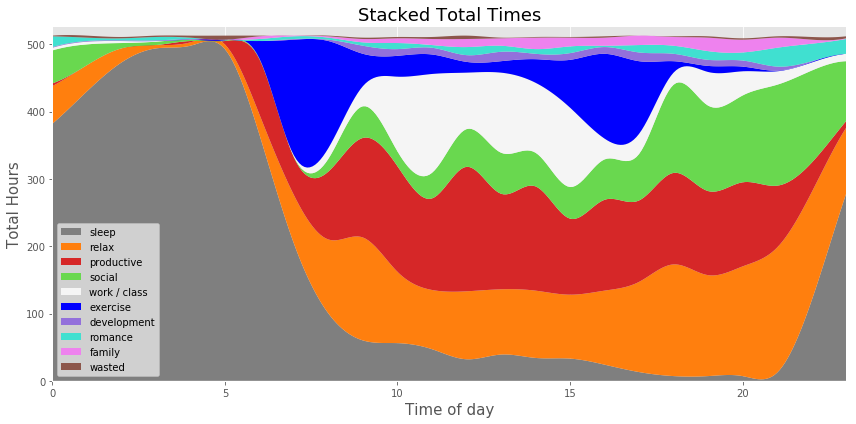

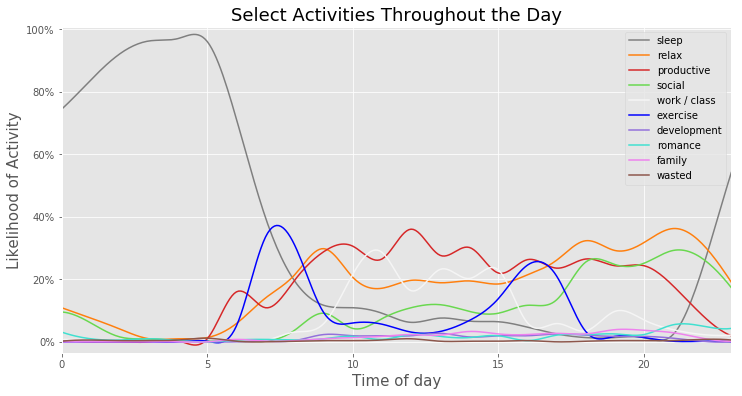

In [12]:
stackedArea(categories, "lower left", shift = 0)
plotLines(categories, "upper right", shift = 0)

**Non-sleep activities:**

/Users/Matt/anaconda3/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


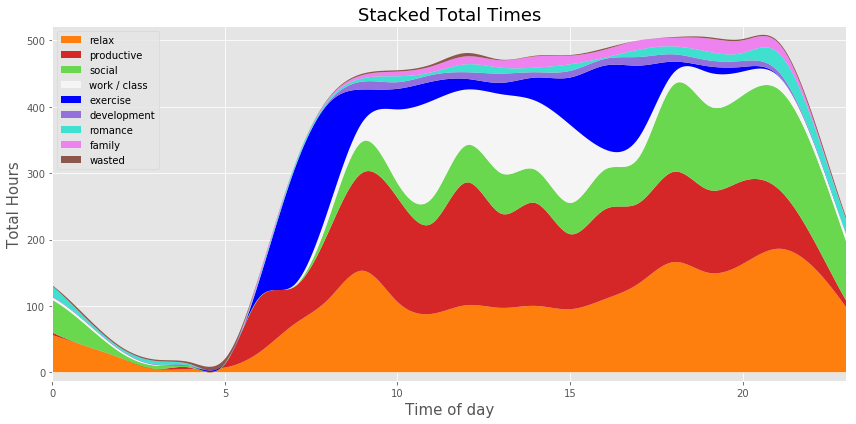

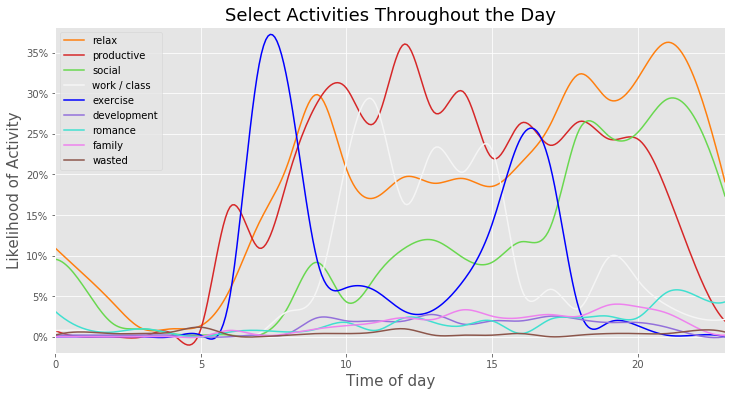

In [13]:
subset = ['relax', 'productive', 'social', 'work / class', 'exercise', 'development', 'romance', 'family', 'wasted']
stackedArea(subset, "upper left")
plotLines(subset, "upper left")

**Accessory-only**

/Users/Matt/anaconda3/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


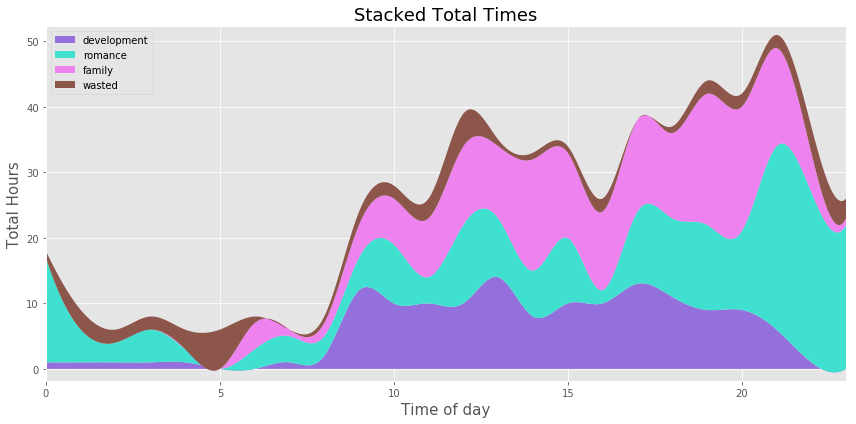

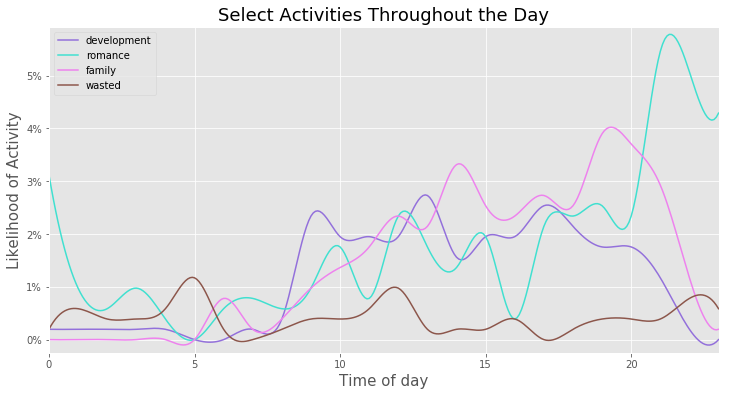

In [14]:
subset = ['development', 'romance', 'family', 'wasted']
stackedArea(subset, "upper left")
plotLines(subset, "upper left")

**Accessories Ignored**

/Users/Matt/anaconda3/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


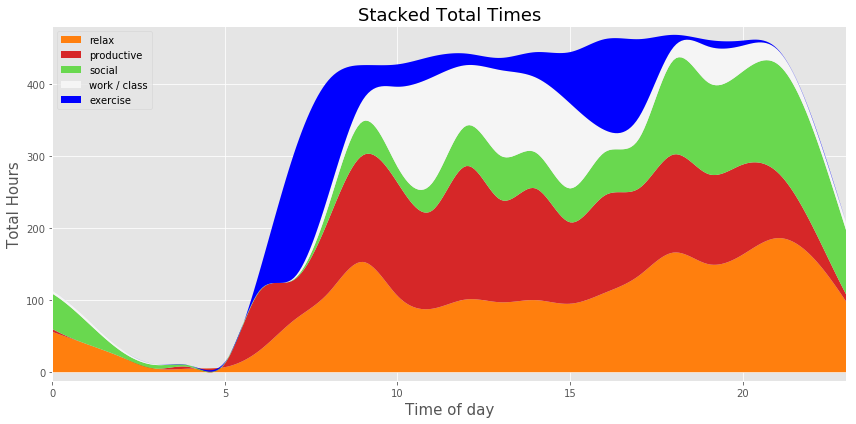

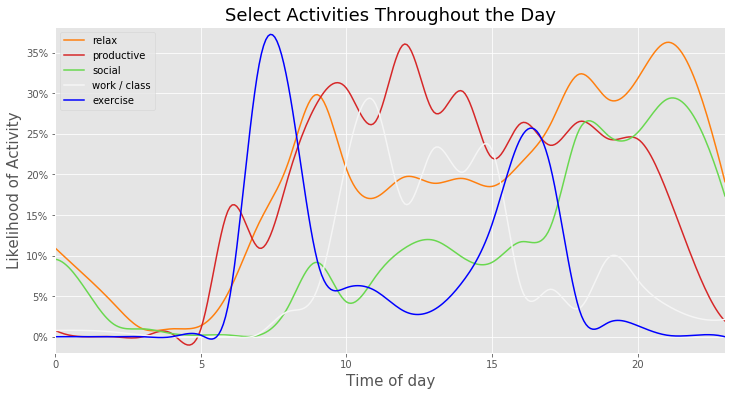

In [15]:
subset = ['relax', 'productive', 'social', 'work / class', 'exercise']
stackedArea(subset, "upper left")
plotLines(subset, "upper left")

### Most likely thing to be doing at X hour

In [16]:
from scipy.interpolate import make_interp_spline, BSpline

def convexHull(subset, legend): 
    
    data = sums_by_time[subset] / NUM_DAYS
    
    fig, ax = plt.subplots(figsize=(12,6))
    plt.margins(0,0.025)

    T = np.arange(len(sums_by_time.index))
    num_points = 300
    names = sums_by_time.columns

    xnew = np.linspace(T.min(),T.max(), num_points) 
    smooth = np.zeros((len(subset), num_points))
    line_color = [0] * num_points
    
    for i in range(0, len(subset)):        
        #BSpline object
        spl = make_interp_spline(T, data[subset[i]], k=3) 
        power_smooth = spl(xnew)

        color_index = categories.index(subset[i])
        plt.plot(xnew, power_smooth, label=subset[i], 
                 c=colors[color_index], alpha=0.5, linewidth=2)
    
    color_index = categories.index(subset[i])
    c=colors[color_index]
    color_subset = [subset]
    
    # get max values and their associated label
    max_line = np.linspace(T.min(),T.max(), num_points)
    for pt in range(0, num_points):
        max_line[pt] = smooth[:, pt].max()
        c = np.where(smooth[:, pt] == max_line[pt])
        c_index = c[0][0]
        color_index = categories.index(subset[c_index])
        line_color[pt] = c=colors[color_index]
        
    
    changed = finished = False
    start = 0
    x = start
    while x < num_points - 1:   
        c = line_color[start]
        for i in range(start, num_points):
            if c != line_color[i]:
                x = i
                changed = True
                break
            elif i == num_points - 1:
                x = num_points
                finished = True
                break
        if changed or finished:
            ax.plot(xnew[start:x], max_line[start:x], 
                    color=line_color[start], linewidth=15)
            start = x
            changed = False
        else:
            break
                
    # manipulate
    plt.ylim(0, 1)     # set the ylim to bottom, top
    vals = ax.get_yticks()
    ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])
        
    ax.legend(loc=legend)
    ax.set_xlabel('Time of day', fontsize=15)
    ax.set_ylabel('Percent likelihood', fontsize=15)
    ax.set_title('Most Likely Thing at X hour', fontsize=18)

    plt.tight_layout()
    plt.show()

**Convex Hull of Everyting:**

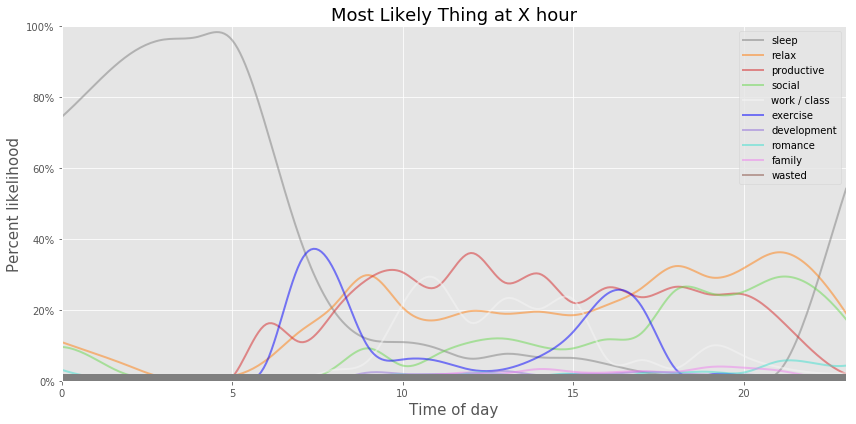

In [17]:
convexHull(categories, "upper right")

### Consider Now, Staggered Area Charts for each Activity in a subset?

In [18]:
from scipy.interpolate import make_interp_spline, BSpline
import numpy.polynomial.polynomial as poly

def yearlongSubmatrices(subset, legend): 
    
    
    # Interpolation overhead
    T = countsDF[subset].index
    num_points = 70
    names = sums_by_time.columns
    xnew = np.linspace(T.min(),T.max(), num_points) 
    smooth = np.zeros((len(subset), num_points))
    
    num_categs = len(subset)
    x = y = 1
    prod = x * y
    while prod < num_categs:
        if x == y:
            y = y + 1
        else: 
            x = x + 1
        prod = x * y
        
    fig, axes = plt.subplots(nrows=x, ncols=y, figsize=(17, 10))
    plt.margins(0,0.025)
    
    for i in range(0, x):
        for j in range(0, y):           
            ind = j + (i * y) 
            if (ind < num_categs):
                
                cat = subset[ind]
                axes[i, j].set_title(str(cat))
                color_index = categories.index(cat)
                
                z = countsDF[cat]
                axes[i, j].plot(z, c=colors[color_index])

                try:
                    spl = make_interp_spline(T, z, k=3) 
                    power_smooth = spl(xnew)
                    axes[i, j].plot(xnew, power_smooth, c='k', alpha=0.8, linewidth=2)

                except:
                    print("error in index: (x: " + str(i) + " , y: " + str(j) + ") ")

                axes[i, j].set_xlabel("Days")
                axes[i, j].set_ylabel("Number Hours")
        
    diff = (x * y) - num_categs
    i = 1
    while (diff > 0):
        axes[x-1, y-i].remove()
        i = i + 1
        diff = diff - 1

    fig.tight_layout()
    plt.show()

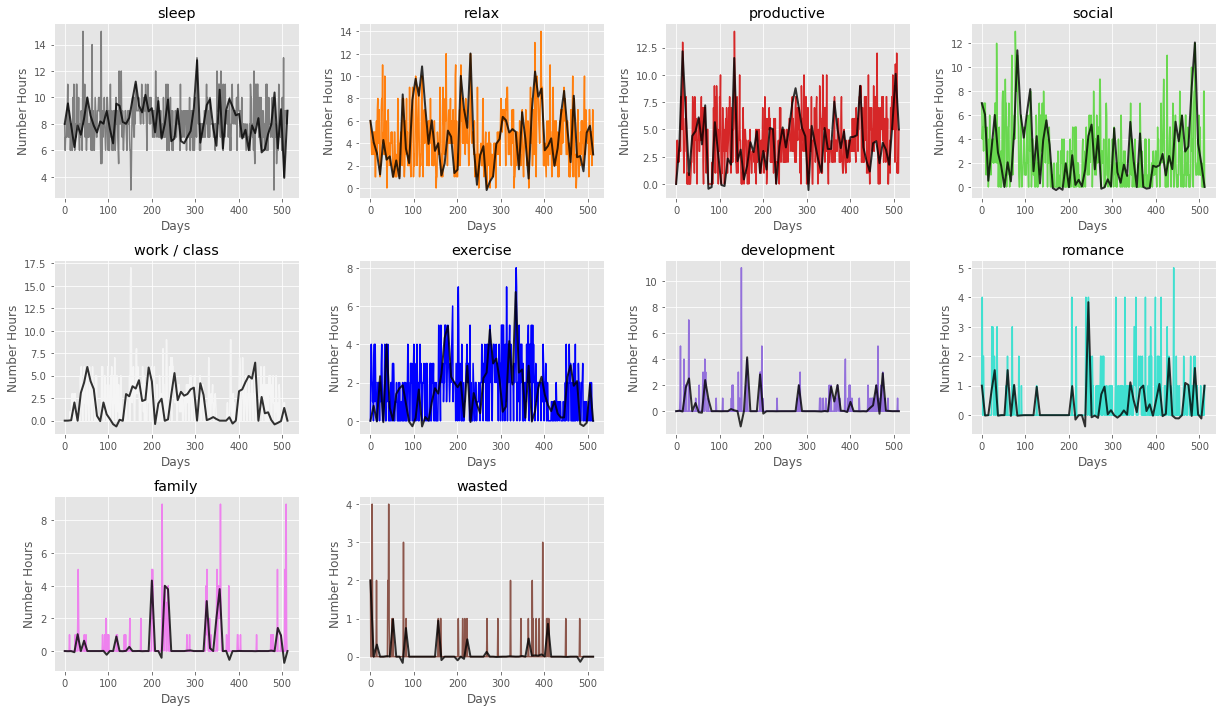

In [19]:
yearlongSubmatrices(categories, "upper left")

# Beginning the ML Portion of the Notebook

### I now train various ML models to recreate/imitate the original dataset

#### Data-encoding methods to explore:
- $K$-Tokenized units, ie $K$ sequential hours grouped as one token
    - Consider $K\in[5, 9]$, so as to handle sleep conditions
    - Consider encoding a "start-time" aspect of the data (ie 'token $x$ began at 3am')
- 10-Dimensional vector (one entry for each of the 10 categories)
    - $X\in\mathbb{R}^{10},\ \ |X| = k$
    - Each $x_i$ reflective of the sum of the $i$'th activity in the $K$ hours
    
#### A list of methods and models to consider:
- Naive Bayes
- Markov model
- Random Forest?